# Course Outline
  * Step 0: 載入套件並下載語料
  * Step 1: 將語料讀進來
  * Step 2: Contingency table 和 keyness 計算公式
  * Step 3: 計算詞頻
  * Step 4: 計算 keyness
  * Step 5: 找出 PTT 兩板的 keywords
  * Step 6: 視覺化


# Step 0: 載入套件並下載語料

In [ ]:
import re # 待會會使用 regular expression
import math # 用來計算 log
import pandas as pd # 用來製作表格
import matplotlib # python 的繪圖套件
import matplotlib.pyplot as plt # 用來畫圖表
from matplotlib.font_manager import FontProperties # 用來顯示中文字型
from wordcloud import WordCloud # 製作文字雲

In [ ]:
# 用來下載 Google Drive 上的文件
# Colab 已內建此指令
!pip install gdown

In [ ]:
# 下載語料 (語料已經過斷詞處理)
!gdown --id "1q3DAwlRaK9mApM_rtdSlfAvhLRotMAQH" -O "WomenTalk_2020_seg.txt" # 2020 年 WomenTalk 板
!gdown --id "1PG_b7CBB6QLELEDBiRmAT9q9DlLNxksV" -O "Gossiping_2020_seg.txt" # 2020 年 Gossiping 板

Downloading...
From: https://drive.google.com/uc?id=1q3DAwlRaK9mApM_rtdSlfAvhLRotMAQH
To: /content/WomenTalk_2020_seg.txt
6.67MB [00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PG_b7CBB6QLELEDBiRmAT9q9DlLNxksV
To: /content/Gossiping_2020_seg.txt
7.80MB [00:00, 47.4MB/s]


In [ ]:
# 如果你想試試不同年份的資料
!gdown --id "1mbtnbe_vjVbq87VEZY-z7T6QgZ3gpjJ9" -O "Gossiping_2015_seg.txt" # 2015 年 Gossiping 板
!gdown --id "1QvmzgrelbcfKWCFra7Yegq7FoWqGVfyL" -O "Gossiping_2010_seg.txt" # 2010 年 Gossiping 板
!gdown --id "1GJycMF7q7tMPf5j4aM-7DAGfIIDH_w0t" -O "Gossiping_2005_seg.txt" # 2005 年 Gossiping 板

!gdown --id "1FL3bvOmkeqDrgMBWGfoVtxBqvX9R_ebW" -O "WomenTalk_2015_seg.txt" # 2015 年 WomenTalk 板
!gdown --id "16-XHG9ceyVVWPZ1NSeCyDMoJn0J84L8e" -O "WomenTalk_2010_seg.txt" # 2010 年 WomenTalk 板
!gdown --id "1MfxuFa9wFjVkknpeXUY19rZbh7jrp64J" -O "WomenTalk_2005_seg.txt" # 2005 年 WomenTalk 板

Downloading...
From: https://drive.google.com/uc?id=1mbtnbe_vjVbq87VEZY-z7T6QgZ3gpjJ9
To: /content/Gossiping_2015_seg.txt
20.8MB [00:00, 40.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QvmzgrelbcfKWCFra7Yegq7FoWqGVfyL
To: /content/Gossiping_2010_seg.txt
100% 1.83M/1.83M [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GJycMF7q7tMPf5j4aM-7DAGfIIDH_w0t
To: /content/Gossiping_2005_seg.txt
2.61MB [00:00, 81.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FL3bvOmkeqDrgMBWGfoVtxBqvX9R_ebW
To: /content/WomenTalk_2015_seg.txt
3.31MB [00:00, 99.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=16-XHG9ceyVVWPZ1NSeCyDMoJn0J84L8e
To: /content/WomenTalk_2010_seg.txt
100% 1.04M/1.04M [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MfxuFa9wFjVkknpeXUY19rZbh7jrp64J
To: /content/WomenTalk_2005_seg.txt
100% 1.40M/1.40M [00:00<00:00, 88.5MB/s]


# Step 1: 將語料讀進來

In [ ]:
# 我們將 2020 年 Gossiping 板當作 target corpus
with open('/content/Gossiping_2020_seg.txt') as f:
  tgt_content = f.read().strip()

# 將 2020 年 WomenTalk 板當作 reference corpus
with open('/content/WomenTalk_2020_seg.txt') as f:
  ref_content = f.read().strip()

In [ ]:
# 已斷詞的語料是用空白分隔每個詞，所以我們現在要把它們拆開
tgt_corpus = re.split('\s+', tgt_content)
ref_corpus = re.split('\s+', ref_content)

# Step 2: Contingency table 和 keyness 計算公式

## 2.1 Contingency Table

* 這是我們接下來計算 keyness 會使用的 contingency table

|            | word       | other word      | total    |
|------------|------------|-----------------|----------|
| tgt_corpus | a          | b               | (a+b) |
| ref_corpus | c          | d               | (c+d) |
| total      | (a+c)      | (b+d)           | (a+b+c+d)|

* 有了 contingency table，就可以知道計算 keyness 所需要的 observed value 和 expected value    
O11 = a  
O12 = b  
O21 = c  
O22 = d    
E11 = ((a+b) * (a+c))/(a+b+c+d)    
E12 = ((a+b) * (b+d))/(a+b+c+d)  
E21 = ((c+d) * (a+c))/(a+b+c+d)   
E22 = ((c+d) * (b+d))/(a+b+c+d)

## 2.2 Keyness 計算公式

* chi-square
$$\chi^2 = \sum_{i=1}^n \frac {(O_i - E_i)^2}{E_i}$$

* log-likelihood  
$$G^2 = 2 \sum_{i=1}^n O_i \times ln \frac{O_i}{E_i}$$

# Step 3: 計算詞頻

首先，讓我們定義一個函式。透過這個函式，我們可以取得一些之後計算需要的數值。

In [ ]:
# make frequency list
def count_freq(corpus):
    word_freq = {}
    other_word_freq = {}
    corpus_size = len(corpus)

    # count word_freq
    for word in corpus:
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

    # count other_word_freq
    for key, value in word_freq.items():
        other_word_freq[key] = corpus_size - value
    
    return word_freq, other_word_freq, corpus_size

## 3.1 練習

In [ ]:
## TODO: 請找出 target corpus 的 corpus size


In [ ]:
## TODO: 請找出 "減肥" 一詞在 target corpus 中出現了幾次


In [ ]:
## TODO: 請找出 "河蟹" 一詞在 reference corpus 中出現了幾次


利用這個函式，我們就可以知道 contingency table 中各欄位的值。

In [ ]:
tgt_freq = count_freq(tgt_corpus)[0]
tgt_other_freq = count_freq(tgt_corpus)[1]
tgt_size = count_freq(tgt_corpus)[2]
ref_freq = count_freq(ref_corpus)[0]
ref_other_freq = count_freq(ref_corpus)[1]
ref_size = count_freq(ref_corpus)[2]

# Step 4: 計算 keyness

現在，我們要定義第二個函式，幫助我們計算 keyness。

In [ ]:
tgt_corpus_words = set(tgt_corpus)
ref_corpus_words = set(ref_corpus)

def get_keyness(word):
  
  # 處理不在 2 個 corpus 中的詞
  if word not in tgt_corpus_words and word not in ref_corpus_words:
    print(f"{word} not found in both corpora")
    return {}

  # 計算 Observed values
  O11 = tgt_freq.get(word, 0.000001) # 為避免數值中有 0 所造成的 error，我們將其換成一個趨近於 0 的數
  O12 = tgt_other_freq.get(word, tgt_size)
  O21 = ref_freq.get(word, 0.000001)
  O22 = ref_other_freq.get(word, ref_size)
  word_total = O11 + O21
  otherword_total = O12 + O22 
  total_size = tgt_size + ref_size

  # 計算 Expected values
  E11 = word_total * tgt_size / total_size
  E12 = otherword_total * tgt_size / total_size
  E21 = word_total * ref_size / total_size
  E22 = otherword_total * ref_size / total_size

  # 計算 chi-square value
  chi2 = (O11 - E11)**2/E11 + (O12 - E12)**2/E12 + (O21 - E21)**2/E21 + (O22 - E22)**2/E22

  # 計算 log-likelihood value
  G2 = 2*(O11*math.log(O11/E11) + O21*math.log(O21/E21) + O12*math.log(O12/E12) + O22*math.log(O22/E22)) 
  
  # 紀錄該詞偏好在哪一個 corpus 中出現
  preference = 'tgt_corpus' if O11>E11 else 'ref_corpus'
  
  result = {'word': word, 'pref': preference, 'chi2': chi2, 'G2': G2}

  return result

## 4.1 練習

In [ ]:
## TODO: 請找出 "台灣" 的 keyness (以 log-likelihood 計算)


In [ ]:
## TODO: 請找出 "喜歡" 偏好在哪一個 corpus 出現


In [ ]:
## TODO: 搜尋 "最好是啦"，會發生什麼事?


接著，我們將兩個 corpus 都丟進去算 keyness。

In [ ]:
all_words = set(tgt_corpus + ref_corpus)

keyness = []
for word in all_words:
    keyness.append(get_keyness(word))

現在我們已經知道兩個 corpus 中全部的字的 keyness 了！


# Step 5: 找出 PTT 兩板的 keywords

為了知道前十名的 keywords，我們要定義最後一個函式。

In [ ]:
def get_topn(data=None, pref='tgt_corpus', sort_by='G2', n=10):
  out = []
  for w in data:
    if w['pref'] == pref:
      out.append(w)
  
  return sorted(out, key=lambda x:x[sort_by], reverse=True)[:n] # 由大到小排序

這個函式預設將取回 target corpus 中前十名的 keywords。排序預設的 measure 是 log-likelihood 值。

## 5.1 練習

In [ ]:
## TODO: 找出 Gossiping 板的前十名 keywords，以 log-likelihood 值排序



In [ ]:
## TODO: 找出 WomenTalk 板的前十名 keywords，以 log-likelihood 值排序



In [ ]:
## TODO: 找出 Gossiping 板的前五名 keywords，以 chi-square 值排序



In [ ]:
## TODO: 找出 WomenTalk 板的前五名 keywords，以 chi-square 值排序



# Step 6. 視覺化

## 6.1 表格

以 Gossiping 板前十名 keywords 為例 (以 log-likelihood 值排序)，將 `list` 型態的結果轉成 `DataFrame`。


In [ ]:
tgt_G2_top10 = get_topn(keyness)
tgt_G2_top10_df = pd.DataFrame(tgt_G2_top10)
tgt_G2_top10_df

,word,pref,chi2,G2
0,中國,tgt_corpus,2141.280249,2440.416732
1,卦,tgt_corpus,1783.951928,2374.213899
2,台灣,tgt_corpus,1955.260280,2108.527661
3,新聞,tgt_corpus,1740.090568,1998.836604
4,柯,tgt_corpus,1022.848097,1297.490043
5,美國,tgt_corpus,1047.899530,1215.179207
6,蟑螂,tgt_corpus,897.489417,1061.776213
7,完整,tgt_corpus,812.411001,1051.849217
8,政府,tgt_corpus,906.442856,1019.902739
9,防疫,tgt_corpus,744.402694,909.280864


### 6.1.1 練習

In [ ]:
## TODO: 將 WomenTalk 板前十名 keywords (以 log-likelihood 值排序) 的結果轉成 DataFrame




###【討論問題】  
* Gossiping 板的 keywords 跟 WomenTalk 板有什麼不一樣？造成兩板用詞差異可能的因素有那些？
* 用 chi-square 和 log-likelihood 所算出的 keyword 結果相似嗎？

## 6.2 長條圖

讓我們進一步把資料呈現成長條圖。

In [ ]:
# 讓 Colab 進行 matplotlib 繪圖時顯示繁體中文
# 下載台北思源黑體
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為台北思源黑體
matplotlib.rc('font', family = 'Taipei Sans TC Beta')

--2020-12-10 07:59:55--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.217.101, 173.194.217.113, 173.194.217.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p3f943onakq26qfo0nu3l3tsbbpip0qg/1607587125000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2020-12-10 07:59:56--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p3f943onakq26qfo0nu3l3tsbbpip0qg/1607587125000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 173.194.218.132, 2607:f8b0:400c:c14::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|1

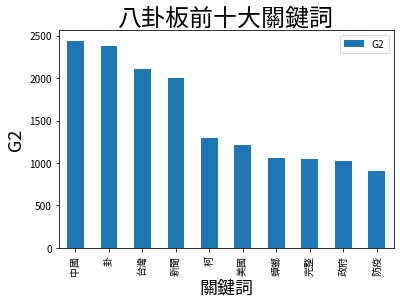

In [ ]:
# 以 Gossiping 板前十名 keywords 為例 (以 log-likelihood 值排序)

tgt_G2_top10_df.plot.bar(x = 'word', y = 'G2')

plt.title('八卦板前十大關鍵詞', fontsize=24) # 標題名稱
plt.xlabel('關鍵詞', fontsize=18) # X軸名稱
plt.ylabel('G2', fontsize=18) # Y軸名稱
plt.show()

### 6.2.1 練習

In [ ]:
# 畫出 WomenTalk 板前十名 keywords (以 log-likelihood 值排序) 的長條圖








## 6.3 文字雲

除了長條圖，我們也可以把資料畫成文字雲。

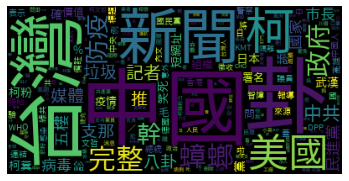

In [ ]:
# 先將八卦板的 keyness 轉成 dictionary
tgt_dict = {i['word']: i['G2'] for i in keyness if i['pref'] == 'tgt_corpus'}

# 製作八卦板關鍵詞文字雲
wordcloud = WordCloud(font_path = 'taipei_sans_tc_beta.ttf')
wordcloud.generate_from_frequencies(frequencies = tgt_dict)
plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 6.3.1 練習

In [ ]:
# 先將女板的 keyness 轉成 dictionary


# 製作女板關鍵詞文字雲





